In [1]:
from pathlib import Path

import torch
import torchvision
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.models.gan import GANDiscriminator, GANGenerator
from torchlake.image_generation.controllers.trainer_gan import GANTrainer
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [3]:
artifact_path = Path("../../artifacts/gan")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/fashionMnist")

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

In [6]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

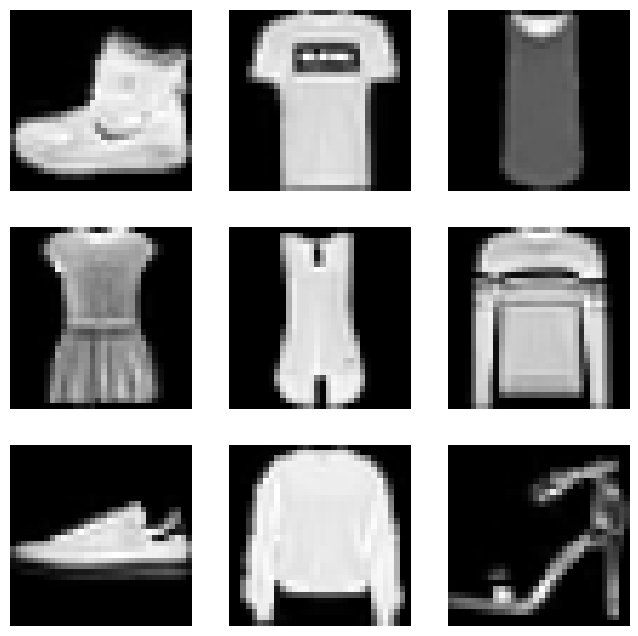

In [8]:
# 資料集繪圖
plot_grids(
    [*img_tensor_to_np(torch.stack([train_data[i][0] for i in range(9)]))],
    num_row=3,
    num_col=3,
    cmap="gray",
)

# model

In [9]:
LATENT_DIM = 128
HIDDEN_DIM = 256

In [10]:
generator = GANGenerator(
    LATENT_DIM,
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
).to(DEVICE)
discriminator = GANDiscriminator(
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
    dropout_prob=0,
).to(DEVICE)

In [11]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
GANGenerator                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       33,024
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,584
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       525,312
│    └─LeakyReLU: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       1,049,600
│    └─Tanh: 2-8                         --
Total params: 1,739,520
Trainable params: 1,739,520
Non-trainable params: 0

In [12]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
GANDiscriminator                         --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       524,800
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,328
│    └─LeakyReLU: 2-4                    --
├─Sequential: 1-3                        --
│    └─Dropout: 2-5                      --
│    └─Linear: 2-6                       257
Total params: 656,385
Trainable params: 656,385
Non-trainable params: 0

# train

In [13]:
from typing import Any, Generator
from torch import Tensor

def noise_generator(batch_size: int) -> Generator[Tensor, Any, None]:
    yield generate_normal(batch_size, LATENT_DIM).to(DEVICE)

In [14]:
EPOCH = 30

In [15]:
trainer = GANTrainer(EPOCH, DEVICE)

In [16]:
from torchlake.common.controller.recorder import TrainRecorder
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=2)
recorder.increment_data_size(len(train_data))

In [17]:
LR = 1e-4
BETA = (0.5, 0.999)

In [18]:
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optim_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [19]:
training_losses = trainer.run(
    train_loader,
    noise_generator,
    generator,
    discriminator,
    optim_G,
    optim_D,
    criterion,
    recorder=recorder,
)

Enable AMP: False


100%|██████████| 468/468 [00:20<00:00, 22.43it/s]


epoch 1: D: 0.004840055216848848 G: 0.006287881134450439


100%|██████████| 468/468 [00:24<00:00, 19.17it/s]


epoch 2: D: 0.009564806268115832 G: 0.013907515093187493


100%|██████████| 468/468 [00:20<00:00, 22.40it/s]


epoch 3: D: 0.014311708869040023 G: 0.022144203496475997


100%|██████████| 468/468 [00:23<00:00, 20.34it/s]


epoch 4: D: 0.019000428966681186 G: 0.03051754316141207


100%|██████████| 468/468 [00:22<00:00, 21.12it/s]


epoch 5: D: 0.023624292592207604 G: 0.03948945021082958


100%|██████████| 468/468 [00:20<00:00, 22.53it/s]


epoch 6: D: 0.027996310307582196 G: 0.04895246714403232


100%|██████████| 468/468 [00:21<00:00, 21.33it/s]


epoch 7: D: 0.032530262613793166 G: 0.05811653604557115


100%|██████████| 468/468 [00:22<00:00, 21.08it/s]


epoch 8: D: 0.03730937920361753 G: 0.06684247338026755


100%|██████████| 468/468 [00:20<00:00, 22.31it/s]


epoch 9: D: 0.04217722256531311 G: 0.07485901659776759


100%|██████████| 468/468 [00:18<00:00, 24.99it/s]


epoch 10: D: 0.04696820806215197 G: 0.0829826799973845


100%|██████████| 468/468 [00:23<00:00, 20.07it/s]


epoch 11: D: 0.05179869022816405 G: 0.09088887020399165


100%|██████████| 468/468 [00:21<00:00, 22.01it/s]


epoch 12: D: 0.05667328234066552 G: 0.0987994185532132


100%|██████████| 468/468 [00:20<00:00, 22.92it/s]


epoch 13: D: 0.06154020223369194 G: 0.10658630021264145


100%|██████████| 468/468 [00:21<00:00, 22.18it/s]


epoch 14: D: 0.06643890194247157 G: 0.11424181021501603


100%|██████████| 468/468 [00:21<00:00, 22.18it/s]


epoch 15: D: 0.07139962794333679 G: 0.1217024690513808


100%|██████████| 468/468 [00:19<00:00, 23.63it/s]


epoch 16: D: 0.07633791199475502 G: 0.1290052611355979


100%|██████████| 468/468 [00:20<00:00, 22.73it/s]


epoch 17: D: 0.08131801656037536 G: 0.13639537239919097


100%|██████████| 468/468 [00:21<00:00, 21.75it/s]


epoch 18: D: 0.08631606128166093 G: 0.1436428881600497


100%|██████████| 468/468 [00:18<00:00, 25.09it/s]


epoch 19: D: 0.09132445409347575 G: 0.1507422046964365


100%|██████████| 468/468 [00:18<00:00, 24.98it/s]


epoch 20: D: 0.09627677711695394 G: 0.15784018301516756


100%|██████████| 468/468 [00:20<00:00, 22.34it/s]


epoch 21: D: 0.10125168830404638 G: 0.16510861719896394


100%|██████████| 468/468 [00:22<00:00, 20.81it/s]


epoch 22: D: 0.10619316582928064 G: 0.17233500247746708


100%|██████████| 468/468 [00:21<00:00, 22.03it/s]


epoch 23: D: 0.11112095649192705 G: 0.1797504482264321


100%|██████████| 468/468 [00:20<00:00, 23.13it/s]


epoch 24: D: 0.11597318054288608 G: 0.1871802751486501


100%|██████████| 468/468 [00:20<00:00, 23.10it/s]


epoch 25: D: 0.12085057404985003 G: 0.19457583265453623


100%|██████████| 468/468 [00:22<00:00, 20.56it/s]


epoch 26: D: 0.12569789064377526 G: 0.2020402281249569


100%|██████████| 468/468 [00:23<00:00, 19.60it/s]


epoch 27: D: 0.13055543917069798 G: 0.2094454938019323


100%|██████████| 468/468 [00:20<00:00, 22.62it/s]


epoch 28: D: 0.1354273608898122 G: 0.21683888592372447


100%|██████████| 468/468 [00:22<00:00, 20.45it/s]


epoch 29: D: 0.14031149882922583 G: 0.22408244443585584


100%|██████████| 468/468 [00:22<00:00, 20.93it/s]

epoch 30: D: 0.14521071540166933 G: 0.2314046859160078


# evaluation

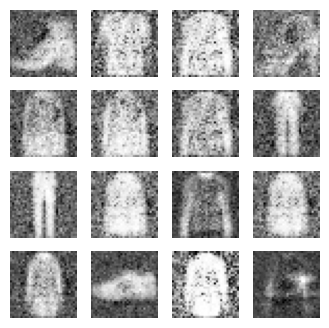

In [20]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_normal(16, LATENT_DIM).to(DEVICE)
    gen_img = generator(noise)
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=4,
        num_col=4,
        is_gray_scale=True,
        figsize=(4,4),
    )

In [21]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 468/468 [00:12<00:00, 38.81it/s]

0.6661166666666667


In [22]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, label in tqdm(train_loader):
        noise = generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 468/468 [00:14<00:00, 32.21it/s]

0.37483333333333335


In [23]:
model_path = artifact_path / 'gan.pth'

In [24]:
torch.save(generator.state_dict(), model_path.as_posix())

In [25]:
generator.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>